# MEPS data entry experiments for Data Bootcamp course

### Goals:
1. Experiment with reading in fixed width format files
2. Reproduce Figure 1 from [2], which plots the cumulutive distribution of total personal health care spending in the US updated for 2012 (latest).
### Sources:
1. [Medical Expenditure Panel Survey (MEPS) HC-155: 2012 Full Year Consilidated Data File](http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-155)
2. [NIHCM Foundation Data Bried, July 2012](http://www.nihcm.org/pdf/DataBrief3%20Final.pdf)

### NOTE:
The data on the [MEPS site](http://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-155) is a .DAT file compressed in .zip format. If the data was compressed in .gz or .bz2 format, the URL for the data could be directly inputted into 'pd.read_fwf()' without having to unzip and download the file before reading it in. The reason for this could be that .gz and .bz2 formats only compress *single* files while .zip formats can potentially contain multiple. This isn't the case here (only one file compressed in the .zip file in the URL below), but if there were more than one than Pandas wouldn't automatically be able to tell which one you're interested in.

-Brian LeBlanc, January 2016
Created with Python 3.5.1

### Importing  the Data from MEPS


In [1]:
import pandas as pd   #The data package

import sys            #The code below wont work for any versions before Python 3. This just ensures that (I guess).
assert sys.version_info >= (3,5)

"""
The MEPS dataset is is compressed in a .zip file in the link above. The code here downloads the .zip file, unzips
and saves the MEPS dataset. 
"""

import requests, io, zipfile     #Three packages we'll need to unzip the data

url = requests.get("http://meps.ahrq.gov/mepsweb/data_files/pufs/h155dat.zip") #Downloads the .DAT file

zipfile = zipfile.ZipFile(io.BytesIO(url.content))                             #Unzips the .DAT file

url_unzipped = zipfile.extract(zipfile.namelist()[0])                          #Extracts/stores the .DAT file

print(zipfile.namelist())   #Unzipped file name


['h155.dat']


### Parsing the Data in the .DAT file

Most of the time, when you open a data file in Python or Stata or Matlab or Excel (etc) the data is already pre-configured with variable names and (maybe) descriptions. This isn't the case here. The .DAT file that we unzipped above contains all the relevent data, but as of now its just a bunch of unorganized datapoints that are each a "fixed width" apart. We'll have to tell Python what data corresponds to what variable and write code to label it ourselves. 

All the info we need can be found in the [codebook](http://meps.ahrq.gov/mepsweb/data_stats/download_data/pufs/h155/h155cb.pdf). The first two columns in the codebook, "Start:" and "End:", are numbers that tell us where in the .DAT file that particular variable is located. 

**Note that if the range of a variable in the codebook is (105,107), it needs to be coded as (104, 107). That is, subtract 1 from the first element in the tuple and leave the other unchanged.**

In [2]:
"""
code format:  tuples are (a, b, c)

a = varable name, b =  column range (start-1,end), x = description 
"""

codes = [('DUPERSID',(8,16),'Person identifier'),
         ('TTLP12X',(1501,1507),"Person's total income"),
         ('FAMINC12',(1507,1513),"Family's total income"),
         ('DOBYY',(204,208),"Date of Birth: Year"),
         ('EDUYRDEG',(248,250),'Year of Education or Highest Degree'),
         ('TOTEXP12',(2676,2682),'Total health care expenditure, 2012'),
         ('PERWT12F',(5302,5314),'FINAL PERSON WEIGHT, 2012'),
         ('SEX',(208,209),'Sex'),
         ('POVLEV12',(1514,1525),'Family Income as % of US Poverty Line')]

colnumbs = [x[1] for x in codes]                    
colnames = [x[0] for x in codes]                                  

df = pd.read_fwf(url_unzipped, 
                colspecs = colnumbs ,names = colnames, header = None)

The goal is to re-create Figure 1 from [here](http://www.nihcm.org/pdf/DataBrief3%20Final.pdf). It paints a pretty vivid picture about the distribution of personal health care spending in the US -- the top 5% of spenders account for nearly 50% of total spending and the top 1% account for more than 20% of the total.

Each observation in the MEPS dataset recieves a weight (PERWT12F) that tells us how many people that observation is supposed to represent. This weighting structure is supposed to make the ~30,000 observations in our sample more representative of the actual ~300 million people in the U.S. The following function (which I took mostly from [here](http://stackoverflow.com/a/29677616/5822268) but added a bit more to it) allows us to calculate percentiles that take into account the sample weights given by the variable PERWT12F. 


In [3]:
df['TOTEXP12_WT'] = df['TOTEXP12']*df['PERWT12F']
df['age'] = 2015-df['DOBYY']
percentiles = [i * 0.1 for i in range(10)] + [0.95, 0.99, 1.00]

def weighted_percentiles(subgroup = None,  limits = []):
    import numpy 
    a, b  = list(), list()
    if subgroup is None:
        tt = df
    else:
        tt = df[df[subgroup].astype(int).isin(range(limits[0],limits[1]+1))] 
    values, sample_weight = tt['TOTEXP12'], tt['PERWT12F']
    for index in percentiles: 
        values = numpy.array(values)
        index = numpy.array(index)
        sample_weight = numpy.array(sample_weight)

        sorter = numpy.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

        weighted_percentiles = numpy.cumsum(sample_weight) - 0.5 * sample_weight
        weighted_percentiles /= numpy.sum(sample_weight)
        a.append(numpy.interp(index, weighted_percentiles, values))
        
    d = [tt.loc[tt['TOTEXP12']<=a[x],'TOTEXP12_WT'].sum()/tt['TOTEXP12_WT'].sum() for x in range(len(percentiles))]
    return d

pd.options.display.float_format = '{:.3f}'.format
age_names = [' <18','18-24','25-44','45-64','65+', 'Total']
income_names = [' < 100%','100%-200%','200%-300%','300%+', 'Total']
age_range = [[0,17],[18,24],[25,45],[45,64],[65,max(df['age'])],[min(df['age'])-1,max(df['age'])+1]]
income_names = [' < 100%','100%-200%','200%-300%','300%+', 'Total']
income_range = [[int(min(df['POVLEV12']))-1,100],[100,200],[200,300],[300,int(max(df['POVLEV12']))+1],
                [int(min(df['POVLEV12']))-1,int(max(df['POVLEV12']))+1]]

df_age = pd.DataFrame({age_names[x] : weighted_percentiles('age',age_range[x]) for x in range(len(age_range))})
df_income = pd.DataFrame({income_names[x] : weighted_percentiles('POVLEV12',income_range[x])
                          for x in range(len(income_range))})

[df_age,df_income] = [df_age.rename(index={x: '{:.2f}'.format(percentiles[x]) for x in range(13)}),
                      df_income.rename(index={x: '{:.2f}'.format(percentiles[x]) for x in range(13)})]
[df_age.index.names,df_income.index.names] = [['Perc.'],['Perc.']]

print('\n INEQUALITY IN PERSONAL HEALTH CARE SPENDING, 2012:\n\n by % of family income above poverty line\n\n', df_income)
print('\n by age group\n\n', df_age)


 INEQUALITY IN PERSONAL HEALTH CARE SPENDING, 2012:

 by % of family income above poverty line

         < 100%  100%-200%  200%-300%  300%+  Total
Perc.                                             
0.00     0.000      0.000      0.000  0.000  0.000
0.10     0.000      0.000      0.000  0.000  0.000
0.20     0.000      0.000      0.000  0.002  0.001
0.30     0.001      0.002      0.003  0.008  0.004
0.40     0.006      0.007      0.010  0.020  0.012
0.50     0.014      0.016      0.023  0.041  0.027
0.60     0.031      0.035      0.046  0.073  0.053
0.70     0.064      0.070      0.087  0.125  0.099
0.80     0.136      0.142      0.164  0.212  0.180
0.90     0.294      0.296      0.327  0.373  0.339
0.95     0.457      0.456      0.496  0.532  0.500
0.99     0.753      0.746      0.788  0.787  0.773
1.00     1.000      1.000      1.000  1.000  1.000

 by age group

         <18  18-24  25-44  45-64   65+  Total
Perc.                                        
0.00  0.000  0.000  0.000  0

The tables above show that personal health care spending is very highly concentrated in the United States. The top 1% of spenders account for over 20% of total spending and the top 5% accounts for nearly 50%. 

It's also clear that the distribution of health care spending is pretty similar within different income groupings. This is not the case for the different age subgroups we consider. The distribution of health care spending is the most equal for elderly people (65+): The top 1% of spenders over 65 account for ~15% of total spending amongst people over 65. The least equal subgroup is children (under 18). Almost 30% of the total health care spending on children comes from the top 1% of spenders.

The graph below makes this more clear. The dotted line in the figure reprents what health care spending would look like if it was perfectly distributed across individuals. That is, if the top 10% of spenders account for 10% of total spending, the top 20% account for 20% of total spending, etc. etc.

The more bowed the actual curve is away from the dotted line, the more unequally distributed is health care spending.

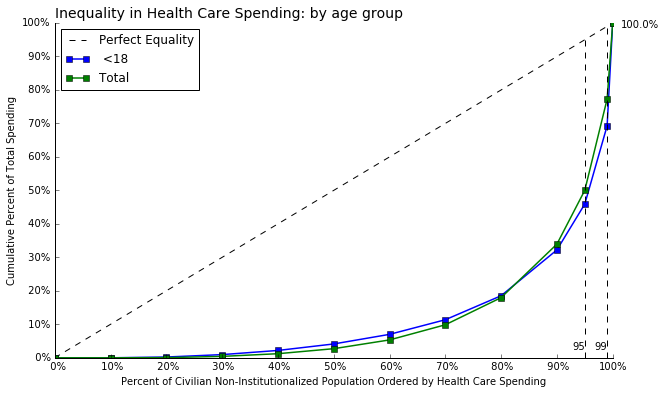

In [4]:
%pylab inline
import matplotlib.pyplot as plt 
from IPython.html.widgets import *

def figureprefs(values, Group, Title = 'text', Labels = False):
    """
    values = variable(s)
    labels = variable labels (appears in legend)
    plot_text = If True, then the text will appear in the graph like in Figure 1 
            from http://www.nihcm.org/pdf/DataBrief3%20Final.pdf.

    """
    fig, ax = plt.subplots(figsize=(10,6))
    [ax.spines[x].set_visible(False) for x in ['right','top']]
    [ax.yaxis.set_ticks_position('left'), ax.xaxis.set_ticks_position('bottom')]
    vals = [i * 0.1 for i in range(11)]
    [ax.set_xticks(vals), ax.set_yticks(vals)]
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    ax.set_title(Title,fontsize=14, loc='left')
    ax.set_ylabel('Cumulative Percent of Total Spending')
    ax.set_xlabel('Percent of Civilian Non-Institutionalized Population Ordered by Health Care Spending')
   
    plt.plot(percentiles,percentiles, linestyle =  '--', color='k',
         label='Perfect Equality')
    plt.plot(percentiles,values[Group], linewidth=1.5, marker='s')
    plt.plot(percentiles,values["Total"], linewidth=1.5, marker='s')            
    
    legend(loc = 2)
    
    [ax.axvline(x=percentiles[y], ymin=0, ymax=percentiles[y], linestyle = '--',
                color = 'k') for y in [10, 11]]
    [ax.annotate(['95','99'][y-10], xy=(percentiles[y], 0.025),horizontalalignment='right', 
                color = 'k', fontsize = 10) for y in [10,11]]
    ax.annotate('{:3.1f}%'.format(values['Total'][12]*100), 
                    xy=(percentiles[12]+0.015, values['Total'][12]-0.015),
                    horizontalalignment='left',annotation_clip=False)
    if Labels is True:
        for num in range(7,12):
            ax.annotate('{:3.1f}%'.format(values[Group][num]*100), 
                    xy=(percentiles[num]-.01, values[Group][num]),
                    color = 'b', ha = 'right', va = 'center', fontsize = 12)
            ax.annotate('{:3.1f}%'.format(values['Total'][num]*100), 
                    xy=(percentiles[num]+.015, values['Total'][num]),
                    color = 'r', ha = 'left', va = 'center', fontsize = 12,annotation_clip=False)
        for index in range(7):
            ax.annotate('{:3.1f}%'.format(values[Group][index]*100), 
                    xy=(percentiles[index]-.01, values[Group][index]+.02),
                    color = 'b', ha = 'right', va = 'center', fontsize = 12)
            ax.annotate('{:3.1f}%'.format(values['Total'][index]*100), 
                    xy=(percentiles[index]+.02, values['Total'][index]+0.01),
                    color = 'r', ha = 'left', va = 'top', fontsize = 12)

interact(figureprefs, values = fixed(df_age), Group = age_names, 
         Title = 'Inequality in Health Care Spending: by age group');
